# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import binary_dilation
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
RAW_DATA_PATH = "../raw_data/"
ADDITIONAL_DATA_PATH = "../additional_data/"

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

In [ ]:
processed_dfs.keys()

dict_keys(['train', 'gas_prices', 'client', 'electricity_prices', 'forecast_weather', 'historical_weather', 'station_county_mapping', 'county_id_to_name_map', 'holidays'])

In [ ]:
df = merge_all_dfs(processed_dfs, how="left")

In [ ]:
# q = pd.merge(
#     left=processed_dfs["train"],
#     right=processed_dfs["client"].drop(columns=["date"]),
#     how="inner",  # Save dtype
#     on=["county", "product_type", "is_business", "data_block_id"],
# )

In [ ]:
df = add_dst_flag(df)

In [ ]:
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
# for lag in [2, 3, 7]:
for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        on=TARGET_C,
    )

In [ ]:
# for window in [24, 24 * 3, 24 * 7, 24 * 14]:
for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            window=window,
        ).dropna(),
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
# df.dtypes

In [ ]:
# w, h = 20, 14

# fig, ax = plt.subplots(figsize=(w, h))
# # plt.figure(figsize=(w, h))

# sns.heatmap(
#     df.drop(
#         columns=df.select_dtypes(["category"]).columns.tolist()
#         + [
#             "datetime",
#             "data_block_id",
#             "date",
#         ]
#     ).corr(),
#     annot=True,
#     fmt=".1f",
#     annot_kws={"size": 7},
# )


# buf = io.BytesIO()
# fig.savefig(buf, format="png", bbox_inches="tight")
# buf.seek(0)
# img_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

# html_code = (
#     '<div style="overflow-x: auto; width: 100%;">'
#     '<img src="data:image/png;base64,{}" style="display: block; max-width: none; width: auto;">'
#     "</div>"
# ).format(img_base64)

# display(HTML(html_code))
# plt.close(fig)
# # plt.show()

# 3. Cross Validation

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# from sktime.split import ExpandingWindowSplitter
# from sktime.forecasting.base import ForecastingHorizon

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

In [ ]:
df["datetime"].is_monotonic_increasing

True

In [ ]:
# from sktime.forecasting.model_selection import SlidingWindowSplitter
# from sktime.split import ExpandingWindowSplitter
# from sktime.forecasting.base import ForecastingHorizon

In [ ]:
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
df["datetime"].dt.date.iloc[0]

datetime.date(2021, 9, 17)

In [ ]:
df["datetime"].max()- pd.Timedelta(days=1)

Timestamp('2023-05-30 23:00:00')

In [ ]:
df["datetime"].dt.floor("D").max()
# - pd.Timedelta(days=1)

Timestamp('2023-05-31 00:00:00')

In [ ]:
# def split_by_days(
#     dt: Series,
#     train_days: int,
#     fh_days: int = 1,  # Same for val and test
#     # step_days: int,
#     val_steps: int = 1,
#     expanding: bool = True,
# ):
    
#     train_days = Timedelta(days=train_days - 1)  # Indexing from 0
#     fh_days = Timedelta(days=fh_days)
#     first_day = df[dt].dt.floor("D").min()
#     last_day = df[dt].dt.floor("D").max()
#     test_start = last_day - fh_days

#     for step in range(steps):
#         current_train = (
#             first_day,
#             first_day + pd.Timedelta(hours=23) + train_days,
#         )
#         current_val = (
#             current_train[1] + pd.Timedelta(hours=1),
#             current_train[1] + fh_days,
#         )
#         test = ()
#     return {"current_train": }

In [ ]:
train_ts = "2022-03-01 00:00:00"
val_ts = "2022-04-01 00:00:00"
test_ts = "2022-05-01 00:00:00"

In [ ]:
# example_df = df.loc[df["datetime"] < test_timestamp]

In [ ]:
# def timestamp_multiple_groups_split(df: DataFrame, train_ts, val_ts, test_ts):
    

In [ ]:
df_train = df[df["datetime"] < train_ts].drop(FEATURES_TO_DROP, axis=1)
df_val = df[
    (df["datetime"] >= train_ts) & (df["datetime"] < val_ts)
].drop(FEATURES_TO_DROP, axis=1)
df_test = df[
    (df["datetime"] >= val_ts) & (df["datetime"] < test_ts)
].drop(FEATURES_TO_DROP, axis=1)

X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
n_estimators = 1000
early_stopping_rounds = 100

In [ ]:
xgbr = XGBRegressor(
    random_state=RAND,
    n_estimators=n_estimators,
    enable_categorical=True,
    eval_metric="mae",
    early_stopping_rounds=early_stopping_rounds,
)

In [ ]:
xgbr.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-mae:247.84991	validation_1-mae:242.96163
[1]	validation_0-mae:177.84722	validation_1-mae:179.32502
[2]	validation_0-mae:129.41770	validation_1-mae:137.93543
[3]	validation_0-mae:96.28791	validation_1-mae:107.86293
[4]	validation_0-mae:73.75488	validation_1-mae:91.77617
[5]	validation_0-mae:58.45185	validation_1-mae:79.40402
[6]	validation_0-mae:48.43478	validation_1-mae:76.64018
[7]	validation_0-mae:41.58518	validation_1-mae:72.98704
[8]	validation_0-mae:37.07842	validation_1-mae:69.74081
[9]	validation_0-mae:34.12928	validation_1-mae:68.23234
[10]	validation_0-mae:32.18711	validation_1-mae:67.08082
[11]	validation_0-mae:30.93361	validation_1-mae:66.35761
[12]	validation_0-mae:30.01659	validation_1-mae:66.12909
[13]	validation_0-mae:29.46775	validation_1-mae:65.82613
[14]	validation_0-mae:28.91062	validation_1-mae:65.60950
[15]	validation_0-mae:28.69042	validation_1-mae:65.58046
[16]	validation_0-mae:27.60238	validation_1-mae:63.43724
[17]	validation_0-mae:27.27352	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

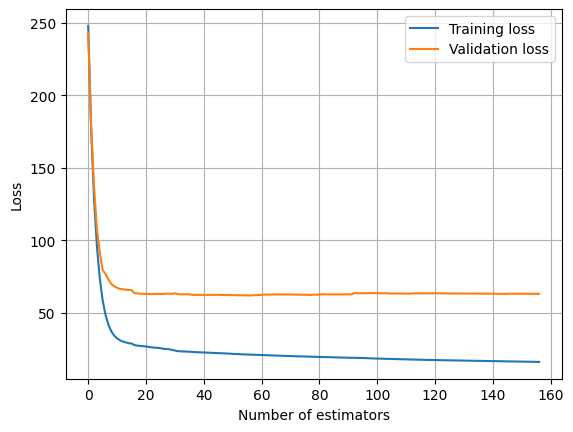

In [ ]:
results = xgbr.evals_result()

plt.plot(results["validation_0"]["mae"], label="Training loss")
plt.plot(results["validation_1"]["mae"], label="Validation loss")

plt.xlabel("Number of estimators")
plt.ylabel("Loss")

plt.legend()
# plt.yscale("log")
plt.grid(which='both')

plt.show()

In [ ]:
y_pred = xgbr.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

76.00541687011719

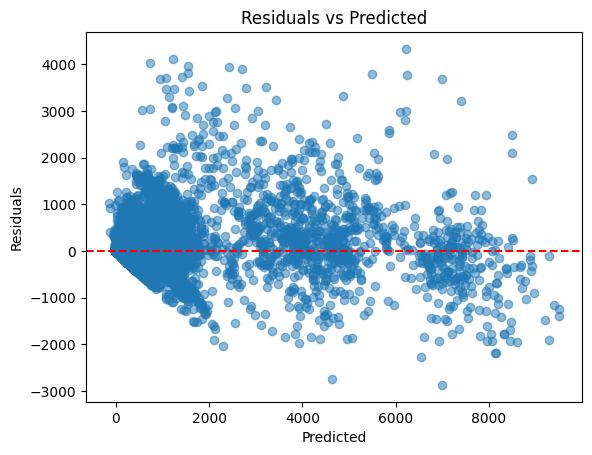

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

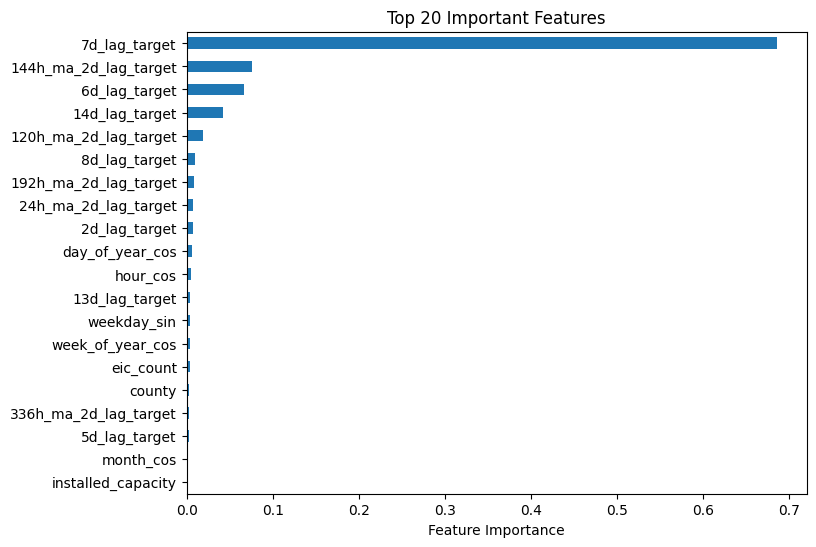

In [ ]:
fi = pd.Series(xgbr.feature_importances_, index=X_train.columns)
fi = fi.sort_values(ascending=False).head(20)

fi.plot.barh(figsize=(8,6))
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.show()